## Image Denoise
In this notebook, we present an image denoise experiment where FCA performs better than ICA.
(This simulation is associated with Figure 4 and Figure 8 in FCA paper.)

In [5]:
push!(LOAD_PATH, "../../src")
using FCA
using Colors, Images, FileIO, Plots, Statistics, LinearAlgebra

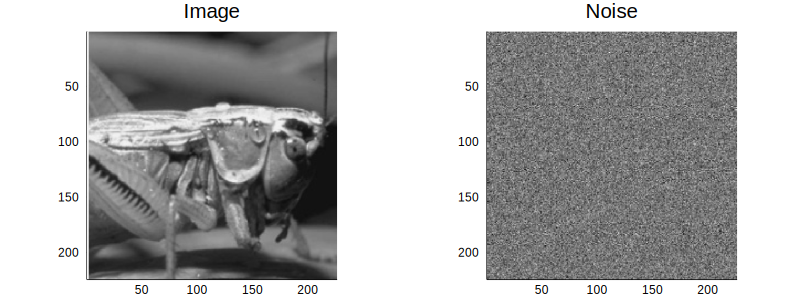

In [6]:
# import the panda image
image = "../images/locust.jpg"; # also try images/locust.jpg
I1 = Float64.(Gray.(load(image)))

# generate the white noise, match the variance
I2 = randn(size(I1))*std(I1)

# plot the original image and noise
p1 = heatmap(I1, yflip=true, color=:grays, aspect_ratio=:equal, title="Image", colorbar = false)
p2 = heatmap(I2, yflip=true, color=:grays, aspect_ratio=:equal, title="Noise", colorbar = false)
plot(p1, p2; size=(800, 300))

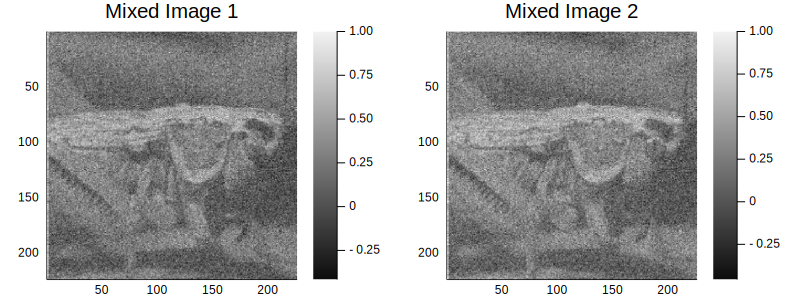

In [7]:
# Noise image
X = [I1, I2]
I1 = 0.0
I2 = 0.0 ## this clears I1 and I2 from memory

# mixing matrix
A = [1 1; 1 -1]/sqrt(2);
Z = A*X

# normalize the mixed images for plot
mixed1 = Z[1]/maximum(Z[1])
mixed2 = Z[2]/maximum(Z[2])

# plot the mixed images
p3 = heatmap(mixed1, yflip=true, color=:grays, aspect_ratio=:equal, title="Mixed Image 1")
p4 = heatmap(mixed2, yflip=true, color=:grays, aspect_ratio=:equal, title="Mixed Image 2")

# release the memory
mixed1, mixed2 = 0.0, 0.0

# show the plot
plot(p3, p4; size=(800, 300))

## Denoise image using icf

In [4]:
# using icf to denoise image
# reshape mixed images to vector
z = [vec(Z[i]) for i = 1: 2]

# apply icf
Aica, xica = icf(z)

([-0.138739 -0.179474; -0.179586 0.137751], Array{Float64,1}[[-4.23999, -4.25522, -4.35638, -4.28886, -4.38772, -4.2888, -4.45299, -4.40955, -4.16558, -4.34334  …  -1.9916, -2.13634, -2.23214, -2.07376, -1.7994, -1.67723, -1.73744, -1.28017, -1.30929, -1.20606], [-1.5464, -1.43023, -0.658381, -1.17354, -0.419274, -1.04112, 0.0786636, -0.252718, -2.11413, -0.757927  …  -2.08507, -0.0503689, 1.21225, 0.801453, -0.627144, -1.16053, -0.169409, -2.329, -0.644634, -0.36881]])

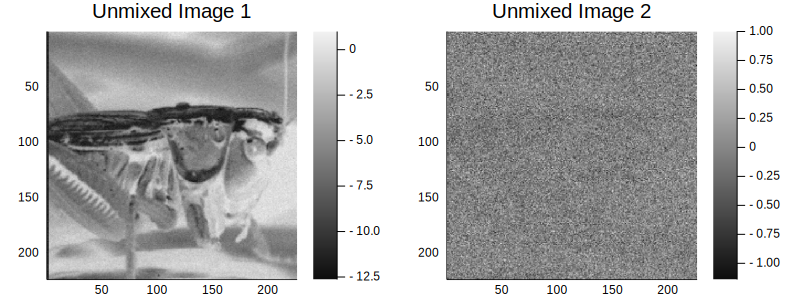

In [5]:
# normalize the unmixed images
unmixed1ica = reshape(xica[1]/maximum(xica[1]), size(Z[1]))
unmixed2ica = reshape(xica[2]/maximum(xica[2]), size(Z[1]))

# Plot the denoised image by icf, note that there is still some noise left.
p5 = heatmap(unmixed1ica, yflip=true, color=:grays, aspect_ratio=:equal, title="Unmixed Image 1")
p6 = heatmap(unmixed2ica, yflip=true, color=:grays, aspect_ratio=:equal, title="Unmixed Image 2")
plot(p5, p6; layout=2, size=(800, 300))

  0.993009 seconds (426.08 k allocations: 445.477 MiB, 11.27% gc time)


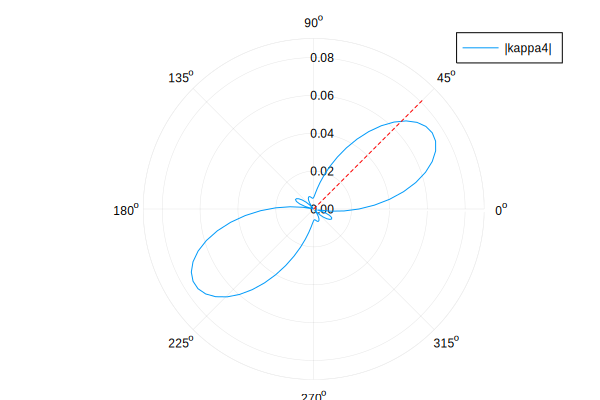

In [89]:
# the direction found by maximize sum of absolute value of kurtosis
# does not recover the independent component

# whiten the original images sepearately 
x = [vec(X[1]), vec(X[2])]
x = [(x[i] .- mean(x[i]))/std(x[i]) for i = 1: 2]

z = A*x
# plot the sum of absolute value of kurtosis vs theta
θ_range = range(0, stop = 2π, length = 100)
@time plot(θ -> -neg_abs_sum_kurt([cos(θ) sin(θ)]*z), 
    θ_range, proj=:polar, label="|kappa4|")
y1, y2 = ylims()
plot!([0, pi/4], [y1, y2], seriestype=:path, proj=:polar, color=:red, label = "", linestyle = :dash,)

## Denoise image using fcf

  8.349726 seconds (6.63 M allocations: 1.366 GiB, 5.96% gc time)


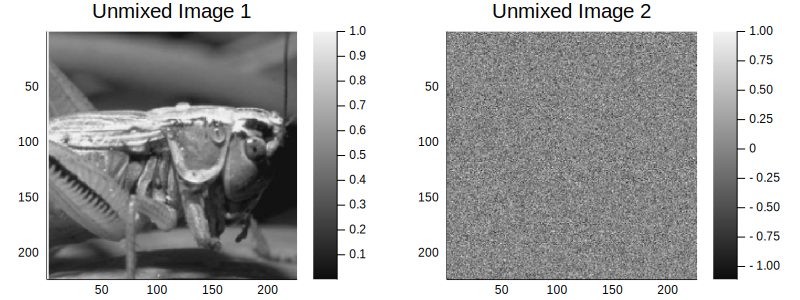

In [6]:
# Apply kurtosis-based freecf to unmix the images
@time Afca, Xfca = freecf(Z; mat = "rec")
 
# normalized the unmixed images 
unmixed1fca = Xfca[1]/maximum(Xfca[1])
unmixed2fca = Xfca[2]/maximum(Xfca[2])

# plot the unmixed images
p7 = heatmap(unmixed1fca, yflip=true, color=:grays, aspect_ratio=:equal, title="Unmixed Image 1")
p8 = heatmap(unmixed2fca, yflip=true, color=:grays, aspect_ratio=:equal, title="Unmixed Image 2")

unmixed1fca = 0.0
unmixed2fca = 0.0

# show the unmixed images, compare it with icf result
plot(p7, p8; layout=2, size=(800, 300))

 11.941433 seconds (42.12 M allocations: 3.058 GiB, 9.81% gc time)


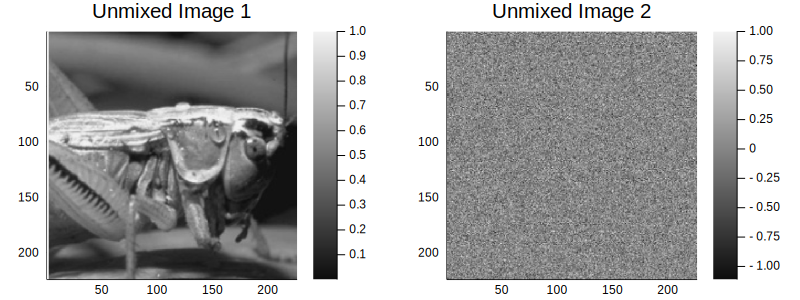

In [7]:
# Apply entropy-based freecf to unmix the images
@time Afca, Xfca = freecf(Z; mat = "rec", obj = "ent")
 
# normalized the unmixed images 
unmixed1fca = Xfca[1]/maximum(Xfca[1])
unmixed2fca = Xfca[2]/maximum(Xfca[2])

# plot the unmixed images
p9 = heatmap(unmixed1fca, yflip=true, color=:grays, aspect_ratio=:equal, title="Unmixed Image 1")
p10 = heatmap(unmixed2fca, yflip=true, color=:grays, aspect_ratio=:equal, title="Unmixed Image 2")

unmixed1fca = 0.0
unmixed2fca = 0.0

# show the unmixed images, compare it with icf result
plot(p9, p10; layout=2, size=(800, 300))

  0.700216 seconds (425.87 k allocations: 444.447 MiB, 11.56% gc time)


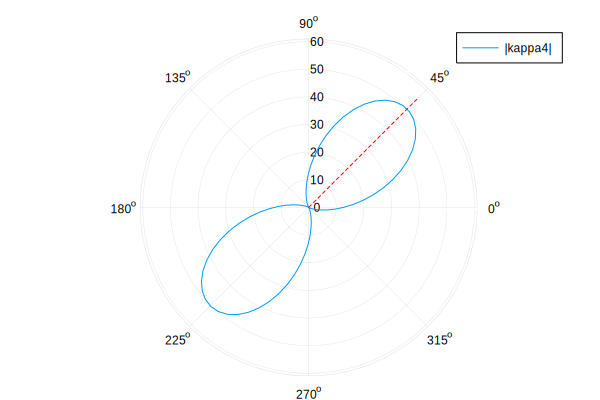

In [67]:
# the direction found by maximize sum of absolute value of free kurtosis
# does recover the independent component

# whiten the original images sepearately 
X = [free_whiten([Xi]; mat = "rec")[1][1] for Xi in X]

Z = A*X
# plot the sum of absolute value of kurtosis vs theta
θ_range = range(0, stop = 2π, length = 100)
@time plot(θ -> -neg_abs_sum_free_kurt([cos(θ) sin(θ)]*Z), 
    θ_range, proj=:polar, label="|kappa4|")
y1, y2 = ylims()
plot!([0, pi/4], [y1, y2], seriestype=:path, proj=:polar, color=:red, label = "", linestyle = :dash)

  6.688137 seconds (40.60 M allocations: 2.598 GiB, 10.57% gc time)


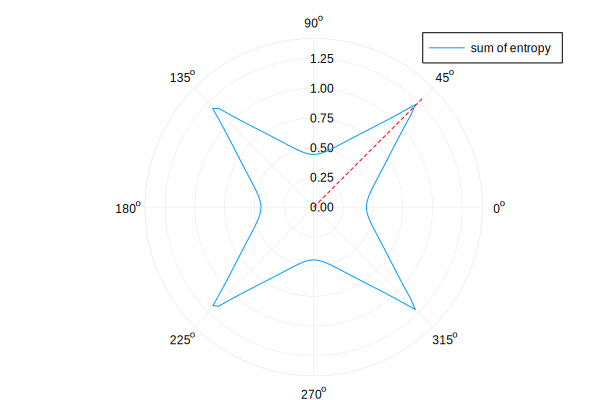

In [104]:
# the direction found by maximize sum of absolute value of free kurtosis
# does recover the independent component

# whiten the original images sepearately 
X = [free_whiten([Xi]; mat = "rec")[1][1] for Xi in X]

Z = A*X
# plot the sum of absolute value of kurtosis vs theta
θ_range = range(0, stop = 2π, length = 200)
@time plot(θ -> -sum_free_ent([cos(θ) sin(θ); -sin(θ) cos(θ)]*Z; mat = "rec"), 
    θ_range, proj=:polar, label="sum of entropy")
y1, y2 = ylims()
plot!([0, pi/4], [y1, y2], seriestype=:path, proj=:polar, color=:red, label = "", linestyle = :dash)

## Embedding

Here we embedding rectangular matrices into self-adjoint matrices or rectangular matrices of other dimension. It turns out that FCF performs well when separating these resulting matrices (this experiment is associated with Section 3.6)

### Self-adjoint embedding

In [8]:
# embed vector into self-adjoint matrix
N,M = 319, 319
Z1 = mat_embed(Z[1], (N,M), tpin = "rec", tpout = "her") # same as reshape in this case
Z2 = mat_embed(Z[2], (N,M), tpin = "rec", tpout = "her") # same as reshape in this case
Zher = [Z1, Z2];

In [9]:
# kurtosis FCA
Aher, _ = freecf(Zher)
@show pinv(Aher)*A

([-6.01098 -2.34556; -6.01868 2.32801], Array{Float64,2}[[0.0 -0.117613 … -0.0595018 -0.00170522; -0.117613 0.0 … -0.0237808 0.000906711; … ; -0.0595018 -0.0237808 … 0.0 -0.0332769; -0.00170522 0.000906711 … -0.0332769 0.0], [0.0 0.0363327 … -0.00452367 -0.01908; 0.0363327 0.0 … 0.00705488 -0.031072; … ; -0.00452367 0.00705488 … 0.0 0.0571409; -0.01908 -0.031072 … 0.0571409 0.0]])

In [12]:
# entropy FCA
Aher, _ = freecf(Zher; obj = "ent")
@show pinv(Aher)*A

pinv(Aher) * A = [-0.117557 0.0021705; -0.000865494 -0.30259]


2×2 Array{Float64,2}:
 -0.117557      0.0021705
 -0.000865494  -0.30259  

### Rectangular embedding

In [31]:
# embed vector into self-adjoint matrix
N,M = 130, 390
Z1 = mat_embed(Z[1], (N,M), tpin = "rec", tpout = "rec") # same as reshape in this case
Z2 = mat_embed(Z[2], (N,M), tpin = "rec", tpout = "rec") # same as reshape in this case
Zrec = [Z1, Z2];

In [32]:
# kurtosis FCA
Arec, _ = freecf(Zher; mat = "rec")
@show pinv(Arec)*A

pinv(Arec) * A = [0.212895 -0.000440307; 1.90257e-5 -0.302598]


2×2 Array{Float64,2}:
 0.212895    -0.000440307
 1.90257e-5  -0.302598   

In [33]:
# entropy FCA
Arec, _ = freecf(Zher; mat = "rec", obj = "ent")
@show pinv(Arec)*A

pinv(Arec) * A = [-0.210412 0.0465448; -0.032422 -0.298997]


2×2 Array{Float64,2}:
 -0.210412   0.0465448
 -0.032422  -0.298997 